In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

### initialize the initial learning rate, number of epochs to train for, and batch size

In [2]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [3]:
DIRECTORY = r"/Hackathon Submission ADSCOS/FaceMask_detection"
CATEGORIES = ["with_mask", "without_mask"]

In [4]:
data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)



### perform one-hot encoding on the labels



In [5]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)

### construct the training image generator for data augmentation

In [6]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")



### load the MobileNetV2 network, ensuring the head FC layer sets are left off

In [7]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

Metal device set to: Apple M1


2022-04-15 19:23:19.407217: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-15 19:23:19.411845: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### construct the head of the model that will be placed on top of the base model

In [8]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

### place the head FC model on top of the base model (this will become the actual model we will train)

In [9]:
model = Model(inputs=baseModel.input, outputs=headModel)

### loop over all layers in the base model and freeze them so they will not be updated during the first training process

In [10]:
for layer in baseModel.layers:
    layer.trainable = False

### compile our model

In [11]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])

/Users/devashish2/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### train the head of the network

In [12]:
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

Epoch 1/20


2022-04-15 19:23:21.453234: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-15 19:23:23.409388: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


149/149 [==============================] - ETA: 0s - loss: 0.3658 - accuracy: 0.8598

2022-04-15 19:24:33.921260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


149/149 [==============================] - 85s 552ms/step - loss: 0.3658 - accuracy: 0.8598 - val_loss: 0.1308 - val_accuracy: 0.9624
Epoch 2/20
149/149 [==============================] - 71s 477ms/step - loss: 0.1484 - accuracy: 0.9536 - val_loss: 0.0868 - val_accuracy: 0.9733
Epoch 3/20
149/149 [==============================] - 34s 226ms/step - loss: 0.1105 - accuracy: 0.9632 - val_loss: 0.0722 - val_accuracy: 0.9750
Epoch 4/20
149/149 [==============================] - 38s 256ms/step - loss: 0.0948 - accuracy: 0.9670 - val_loss: 0.0627 - val_accuracy: 0.9791
Epoch 5/20
149/149 [==============================] - 42s 283ms/step - loss: 0.0872 - accuracy: 0.9674 - val_loss: 0.0572 - val_accuracy: 0.9800
Epoch 6/20
149/149 [==============================] - 46s 305ms/step - loss: 0.0821 - accuracy: 0.9712 - val_loss: 0.0542 - val_accuracy: 0.9808
Epoch 7/20
149/149 [==============================] - 44s 297ms/step - loss: 0.0727 - accuracy: 0.9750 - val_loss: 0.0509 - val_accuracy: 0.9

### make predictions on the testing set

In [13]:
predIdxs = model.predict(testX, batch_size=BS)

2022-04-15 19:49:19.320838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


### for each image in the testing set we need to find the index of the label with corresponding largest predicted probability

In [14]:
predIdxs = np.argmax(predIdxs, axis=1)

### show a nicely formatted classification report


In [15]:
print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.98      0.99      0.99       599
without_mask       0.99      0.98      0.99       599

    accuracy                           0.99      1198
   macro avg       0.99      0.99      0.99      1198
weighted avg       0.99      0.99      0.99      1198



### serialize the model to disk

In [16]:
model.save("mask_detector.model", save_format="h5")

### plot the training loss and accuracy



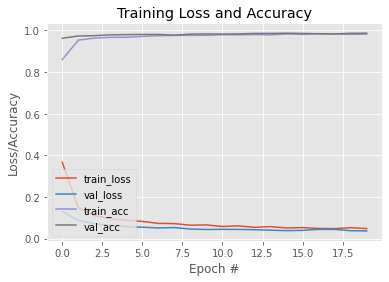

In [17]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_